# 主要思想
- 利用中位数进行滤波，分别得到输入和输出的基准线。
- 利用滤波后输入的基准线预测输出的基准线。
- 设置阈值提取输入基准线的凸起。
- 利用输入的凸起预测输出的凸起。

换句话说，方法会训练两个回归器，一个用于滤波后基准线的回归，一个用于凸起的回归。

以下是比较重要的几个参数：
- filter_win：中位数滤波时窗口大小。
- peak_thresh：凸起阈值。
- peak_space：凸起间隔，用于筛选过于稠密的凸起。

In [1]:
from utils.mideadata import MideaData
from utils.mdlf import MideaDataLF
from utils.evaluate import np_mae, np_mape, np_rmse
import matplotlib.pyplot as plt
import random
import numpy as np

# 数据加载与中位数滤波

In [2]:
cls = "13DKB"
test_cls = '1H'
data = MideaData(cls=[cls])
train_data, test_data = data.get_ori_data(cls=cls, test_cls=test_cls)

In [3]:
train_data[0][1].shape

(20001, 3)

In [5]:
filter_win = 200
x_len = train_data[0][1].shape[0]

x_space = 1 #20000 // x_len
abnormal_list = ['2H', '2V']

filter_train_data, filter_abnormal_train_data = [], []
for name, data in train_data:
    filter_data = []
    for i in range(data.shape[0]):
        filter_data.append([data[i, 0], \
            np.median(data[max(0,i-filter_win):i+filter_win, 1]), \
            np.median(data[max(0,i-filter_win):i+filter_win, 2])])
    filter_data = np.asarray(filter_data)
    if name in abnormal_list:
        filter_abnormal_train_data.append((name, filter_data, data))
    else:
        filter_train_data.append((name, filter_data, data))

输入输出曲线滤波后效果。

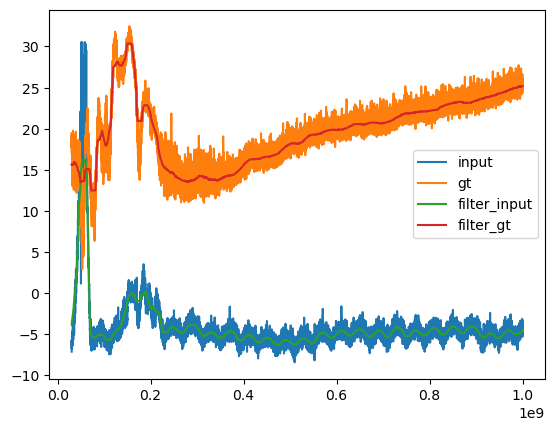

In [6]:
idx = 0
plt.plot(filter_train_data[idx][2][:,0], filter_train_data[idx][2][:,1], label='input')
plt.plot(filter_train_data[idx][2][:,0], filter_train_data[idx][2][:,2], label='gt')
plt.plot(filter_train_data[idx][1][:,0], filter_train_data[idx][1][:,1], label='filter_input')
plt.plot(filter_train_data[idx][1][:,0], filter_train_data[idx][1][:,2], label='filter_gt')
plt.legend()
plt.show()

可以看到，利用中位数滤波以后，即便对于异常数据也可以避免凸起影响，获得基准。

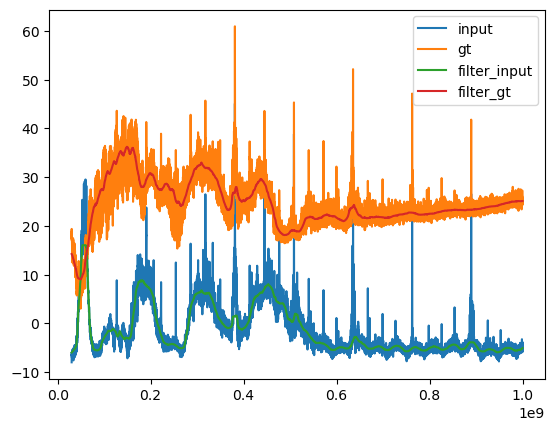

In [7]:
idx = 0
plt.plot(filter_abnormal_train_data[idx][2][:,0], filter_abnormal_train_data[idx][2][:,1], label='input')
plt.plot(filter_abnormal_train_data[idx][2][:,0], filter_abnormal_train_data[idx][2][:,2], label='gt')
plt.plot(filter_abnormal_train_data[idx][1][:,0], filter_abnormal_train_data[idx][1][:,1], label='filter_input')
plt.plot(filter_abnormal_train_data[idx][1][:,0], filter_abnormal_train_data[idx][1][:,2], label='filter_gt')
plt.legend()
plt.show()

# 训练基准线回归器

In [8]:
reg_train = np.vstack([data for name, data, _ in filter_train_data if name not in abnormal_list])

In [9]:
reg_train.shape

(460023, 3)

In [10]:
filter_test_data = []
for name, data in test_data:
    filter_data = []
    for i in range(data.shape[0]):
        filter_data.append([data[i, 0], \
            np.median(data[max(0,i-filter_win):i+filter_win, 1]), \
            np.median(data[max(0,i-filter_win):i+filter_win, 2])])
    filter_data = np.asarray(filter_data)
    filter_test_data.append((name, filter_data, data))

## 线性回归器

In [11]:
from sklearn.linear_model import LinearRegression

normal_reg = LinearRegression().fit(reg_train[:, :2], reg_train[:, 2])

In [12]:
print(normal_reg.coef_, normal_reg.intercept_)

[1.36752343e-08 6.93793906e-01] 14.886802530099343


线性回归效果一般。

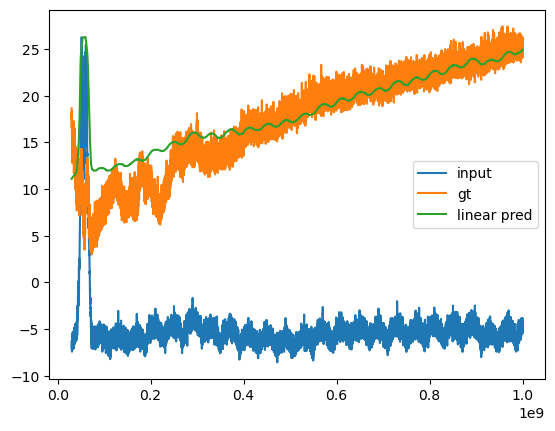

In [13]:
for (name, filter_data, data) in filter_test_data:
    pred = normal_reg.predict(filter_data[:, :2])
    plt.plot(data[:,0], data[:,1], label='input')
    plt.plot(data[:,0], data[:,2], label='gt')
    plt.plot(filter_data[:,0], pred, label='linear pred')
    plt.legend()
    plt.show()

## GBM回归器

GBM效果较好

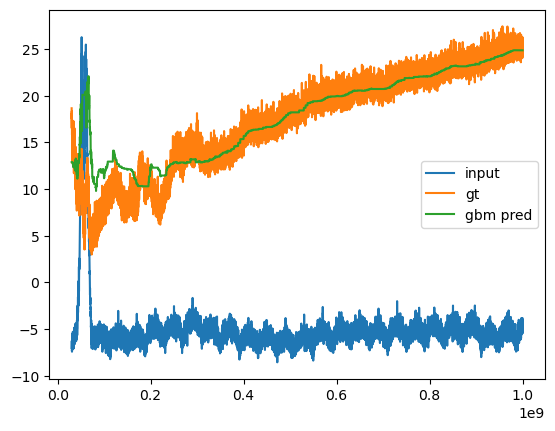

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

normal_gbm_reg = GradientBoostingRegressor()
normal_gbm_reg.fit(reg_train[:, :2], reg_train[:, 2])
for (name, filter_data, data) in filter_test_data:
    pred = normal_gbm_reg.predict(filter_data[:, :2])
    plt.plot(data[:,0], data[:,1], label='input')
    plt.plot(data[:,0], data[:,2], label='gt')
    plt.plot(filter_data[:,0], pred, label='gbm pred')
    plt.legend()
    plt.show()

# 凸起回归器

整理输入曲线的凸起。

简单来说，如果一个数据点距离滤波后的基准线比较远，则认为它是凸起。

(20001, 3) (20001, 3)


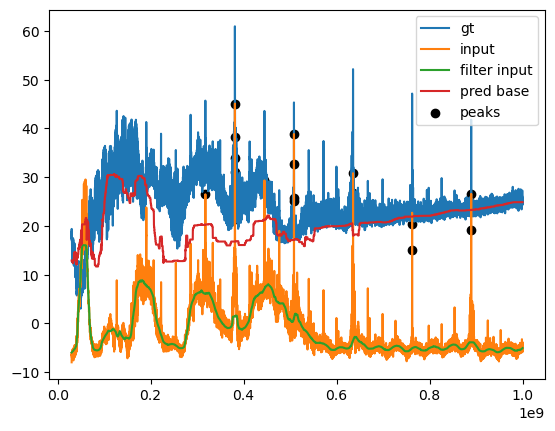

In [15]:
peak_thresh = 20

raw_peak_list = []

# for (name, filter_data, data) in filter_abnormal_train_data:
(name, filter_data, data) = filter_abnormal_train_data[0]
print(data.shape, filter_data.shape)
for i in range(data.shape[0]):
    if data[i, 1] - filter_data[i, 1] > peak_thresh:
        raw_peak_list.append((i, data[i, 1] - filter_data[i, 1]))
pred_base = normal_gbm_reg.predict(filter_data[:, :2])
plt.figure()
plt.plot(data[:,0], data[:,2], label='gt')
plt.plot(data[:,0], data[:,1], label='input')
plt.plot(filter_data[:,0], filter_data[:,1], label='filter input')
plt.plot(data[:,0], pred_base, label='pred base')
# for i,_ in raw_peak_list:
idx = [i for i,_ in raw_peak_list]
plt.scatter(data[idx,0], data[idx,1], color='black', label='peaks')
plt.legend()
plt.show()


原始数据中，凸起通常是成片发生的。实际上，连续成片的凸起只应算作一个，以下对其进行过滤。

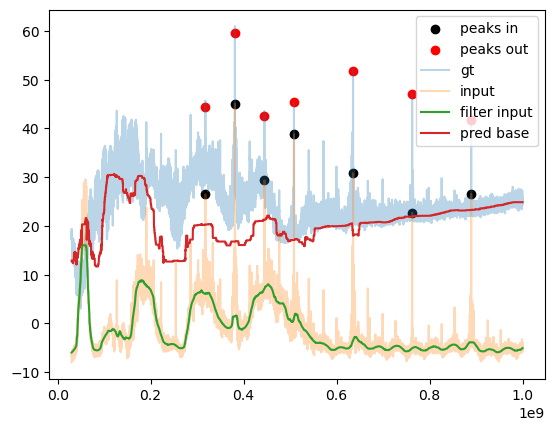

In [16]:
peak_space = 300

peak_list = []
for i, delta in raw_peak_list:
    if len(peak_list)==0 or (i - peak_list[-1][0]) > peak_space:            
        peak_list.append([i, delta])
    else:
        if delta > peak_list[-1][1] and (i - peak_list[-1][0]) < peak_space:
            peak_list.pop()
            peak_list.append([i, delta])
for peak_tuple in peak_list:
    i, delta = peak_tuple
    delta1 = np.max(data[i-peak_space//2:i+peak_space//2, 2]) - pred[i]
    peak_tuple.append(delta1)
plt.figure()
idx = [i for i,_,_ in peak_list]
plt.scatter(data[idx,0], data[idx,1], color='black', label='peaks in')
plt.scatter(data[idx,0], data[idx,2], color='red', label='peaks out')
plt.plot(data[:,0], data[:,2], label='gt', alpha=0.3)
plt.plot(data[:,0], data[:,1], label='input', alpha=0.3)
plt.plot(filter_data[:,0], filter_data[:,1], label='filter input')
plt.plot(data[:,0], pred_base, label='pred base')
# for i,_ in raw_peak_list:
plt.legend()
plt.show()

利用GBM训练凸起回归器。

In [17]:
peak_data = np.asarray(peak_list)
peak_data[:,0] = data[peak_data[:,0].astype(int), 0]
print(peak_data.shape)

(7, 3)


In [18]:
peak_gbm_reg = GradientBoostingRegressor()
peak_gbm_reg.fit(peak_data[:, :2], peak_data[:, 2])

GradientBoostingRegressor()

# 模型推断

训练好基准回归器和凸起回归器之后，模型推断基本也遵循同样的逻辑：
- 对于输入曲线，进行中位数滤波。
- 利用滤波后输入基准线，预测输出基准线。
- 提取输入曲线中的凸起。
- 利用输入凸起预测输出凸起。
- 整合基准回归器与凸起回归器的结果，进行可视化。

(20001, 3) (20001, 3)


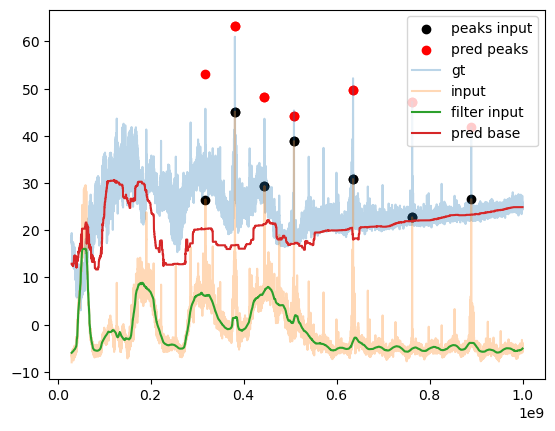

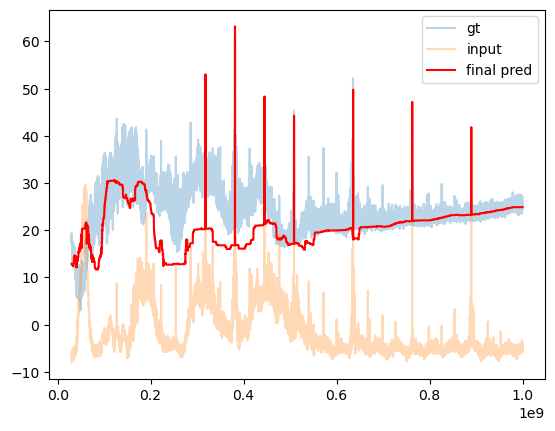

(20001, 3) (20001, 3)


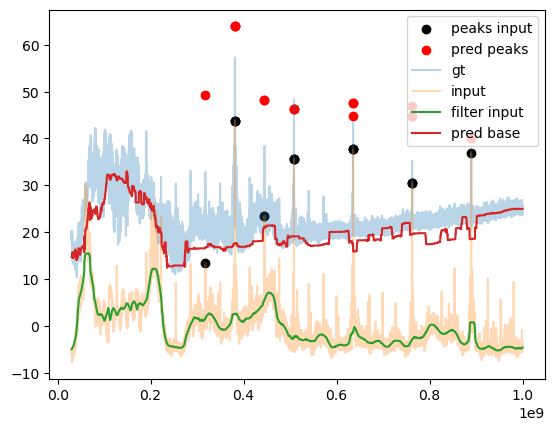

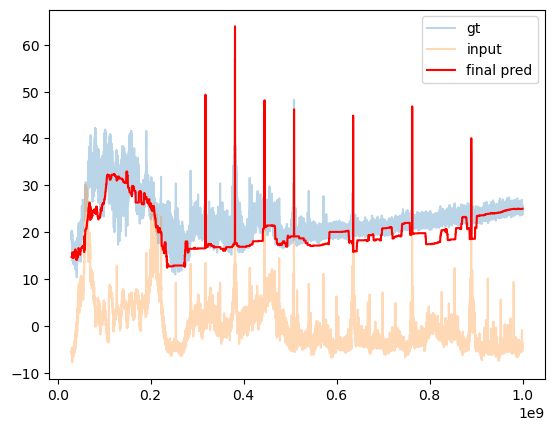

In [19]:
for (name, filter_data, data) in filter_abnormal_train_data:
    print(data.shape, filter_data.shape)
    for i in range(data.shape[0]):
        if data[i, 1] - filter_data[i, 1] > peak_thresh:
            raw_peak_list.append((i, data[i, 1] - filter_data[i, 1]))
    pred_base = normal_gbm_reg.predict(filter_data[:, :2])
    #
    peak_list = []
    for i, delta in raw_peak_list:
        if len(peak_list)==0 or (i - peak_list[-1][0]) > peak_space:            
            peak_list.append([i, delta])
        else:
            if delta > peak_list[-1][1] and (i - peak_list[-1][0]) < peak_space:
                peak_list.pop()
                peak_list.append([i, delta])
    peak_data = np.asarray(peak_list)
    peak_data[:,0] = data[peak_data[:,0].astype(int), 0]
    pred_peak = peak_gbm_reg.predict(peak_data[:, :2])
    for i in range(len(pred_peak)):
        pred_peak[i] += pred_base[peak_list[i][0]]
        
    plt.figure()
    idx = [i for i,_ in peak_list]
    plt.scatter(data[idx,0], data[idx,1], color='black', label='peaks input')
    plt.scatter(data[idx,0], pred_peak, color='red', label='pred peaks')
    plt.plot(data[:,0], data[:,2], label='gt', alpha=0.3)
    plt.plot(data[:,0], data[:,1], label='input', alpha=0.3)
    plt.plot(filter_data[:,0], filter_data[:,1], label='filter input')
    plt.plot(data[:,0], pred_base, label='pred base')
    plt.legend()
    plt.show()

    final_pred = pred_base.copy()
    for k, (i, delta) in enumerate(peak_list):
        final_pred[i:i+5] = pred_peak[k]
    plt.figure()
    idx = [i for i,_ in peak_list]
    plt.plot(data[:,0], data[:,2], label='gt', alpha=0.3)
    plt.plot(data[:,0], data[:,1], label='input', alpha=0.3)
    plt.plot(data[:,0], final_pred, color='red', label='final pred')
    plt.legend()
    plt.show()

# Future Work
- 根据以上方法，实现具体的训练推断pipeline，集成到现有系统。尤其是：
    - 控制划分训练集测试集。
    - 利用多个异常数据训练凸起回归器。
- 对于基准线回归和凸起回归尝试使用不同的模型。
- 计算数值指标。
- 在其他品类数据上尝试该方法。
- 针对不同数据集选择重要超参。